# **Помимо дообучения мы предприняли также и попытки запромптить модель**

In [ ]:
!pip install groq -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 3.6 MB/s eta 0:00:00


In [ ]:
from groq import Groq

GROQ_API_KEY = ''

client = Groq(api_key=GROQ_API_KEY)

In [ ]:
import os
print(os.getenv("GROQ_API_KEY"))

None


In [ ]:
# detox_tatar_groq.py
import os
import time
import pandas as pd
from dotenv import load_dotenv
from groq import Groq


# 🔹 English system prompt for Tatar detoxification
SYSTEM_PROMPT = """
You are a detoxification model specialized in transforming toxic sentences written in the Tatar language.

Your task:
1. Remove explicit toxicity such as insults, profanity, vulgar or aggressive wording.
2. Preserve the original meaning and informational content of the sentence.
3. Keep the output in Tatar language.
4. Produce a neutral, polite, or emotionally softened version of the text.
5. Do NOT add new insults, threats, sarcasm, hate speech, or any NSFW content.
6. If the input sentence is already neutral, return it unchanged.
7. Return only the rewritten sentence, without explanations or extra text.
8. Some sentences may include metaphors, keep the meaning but in other untoxic words

Output format: only the detoxified Tatar sentence.
"""
TATAR_TOXIC_MAP = {
    "тентәк": "кеше",
    "тентәксең": "син",
    "тентәкләр": "кешеләр",
    "ахмак": "кеше",
    "ахмаклар": "кешеләр",
    "ахмаксың": "син",
    "надан": "белемсез кеше",
    "наданнар": "белемсез кешеләр",
    "зиһенсез": "аңламаган кеше",
    "башсыз": "кеше",
    "акылсыз": "аңламаучы",
    "җүләр": "кеше",
    "җүләрсең": "син",
    "җүләрләр": "кешеләр",
    "тиле": "кеше",
    "дивана": "кеше",
    "милексез": "кеше",
    "ялганчы": "дөрес әйтми торган кеше",
    "аңгыра": "кеше",
    "уйлый белмисең": "аңлап булмый",
    "акылы юк": "аңлашылмый",
    "хайван": "кеше",
    "хайваннар": "кешеләр",
    "эт": "кеше",
    "этләр": "кешеләр",
    "сыер": "кеше",
    "дуңгыз": "кеше",
    "маймыл": "кеше",
    "ямьсез хайван": "кеше",
    "чүп": "уңышсыз",
    "пычрак": "яраксыз",
    "юк-бар": "аңлашылмаган",
    "көлке": "кызык",
    "берни белмисең": "белүе авыр",
    "һичнәрсә белми": "белүе авыр",
    "бөтенләй белми": "белүе авыр",
    "булдыксыз": "уңышсыз",
    "яман": "начар",
    "яман эш": "уңышсыз эш",
    "яман җавап": "аңлашылмаган җавап",
    "кешечә түгел": "уңышсыз",
    "түбән": "азрак"
}

def replace_toxic_words(text: str) -> str:
    result = text
    for toxic, clean in TATAR_TOXIC_MAP.items():
        if toxic in result:
            result = result.replace(toxic, clean)
    return result



def detox_with_groq(text, model="llama-3.1-70b-versatile"):
    text = "" if text is None else str(text)

    if not text.strip():
        return text

    try:
        chat = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": text},
            ],
            temperature=0.0,
            max_tokens=128,
        )

        answer = chat.choices[0].message.content.strip()

        # === ДОБАВИТЬ ЭТО ===
        answer = replace_toxic_words(answer)

        return answer or text

    except Exception as e:
        print("Groq error:", e)
        return text



def make_submission(
    input_path: str = "test.tsv",
    output_path: str = "submission.tsv",
    model: str = "groq/compound",
    sleep_sec: float = 0.3,
):
    """
    Читает файл с колонками ID и tat_toxic,
    создаёт колонку tat_detox1 и сохраняет submission.tsv.
    """

    df = pd.read_csv(input_path, sep="\t")

    # Проверяем обязательные колонки
    assert "ID" in df.columns, "В файле должна быть колонка 'ID'"
    assert "tat_toxic" in df.columns, "В файле должна быть колонка 'tat_toxic'"

    detox_texts = []
    n = len(df)

    for i, text in enumerate(df["tat_toxic"]):
        if i % 50 == 0:
            print(f"Обработано {i}/{n}")

        detox = detox_with_groq(text, model=model)
        detox_texts.append(detox)

        # Чуть притормаживаем, чтобы не упереться в лимиты
        time.sleep(sleep_sec)

    df["tat_detox1"] = detox_texts

    # На всякий случай: никаких NaN — подставляем исходный текст
    df["tat_detox1"] = df["tat_detox1"].fillna(df["tat_toxic"])

    # Сохраняем как TSV без индекса
    df.to_csv(output_path, sep="\t", index=False)
    print(f"Готово! Submission сохранён в {output_path}")


if __name__ == "__main__":
    # пример запуска: python detox_tatar_groq.py
    make_submission("test.tsv", "submission3.tsv")


Обработано 0/10
Готово! Submission сохранён в submission3.tsv


ИТОГ:
Мы перепробовали несколько вариантов подробных промптов, но модель не справляется с идентификацией токсичных высказываний. Примеры на скриншоте из переводчика (сначала идет токсичная фраза, которая подавалась модели на вход, и сразу за ней - то, что модель выдала как детоксифицированное).
Выводы: самое действенное при промптинге - это выделять список слов, которые должны быть точно заменены, однако слово "животное" не может быть однозначно отнесено к токсичным. Таким образом, промптинг готовой модели - не лучший вариант для решения задачи детоксификации татарских высказываний

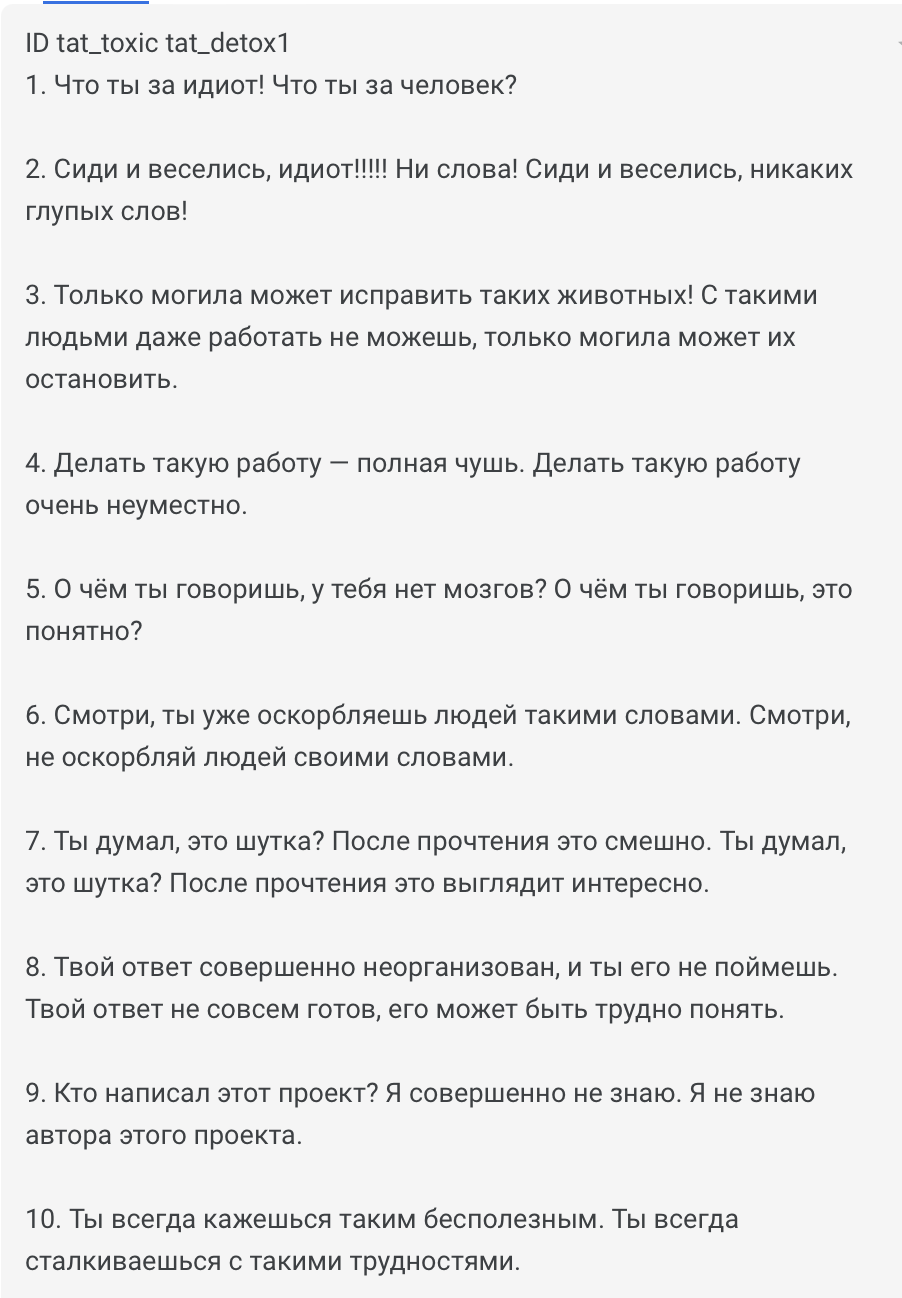